In [1]:
using Distributions
using LinearAlgebra
using Plots
using DataFrames
using CSV
include("../experiments/cartpole-beta.jl")
;

load done: 20.013


In [178]:
DUMP_DIR = joinpath(@__DIR__, "..", "dump", "random-beta")

colors = palette(:auto)
;

In [179]:
function loadDataFrame(dim)
    basename = "randw40_dim$(dim).csv"
    filepath = joinpath(DUMP_DIR, basename)
    return CSV.File(filepath)
end

function loadBounds()
    csv1 = loadDataFrame(1)
    csv2 = loadDataFrame(2)
    csv3 = loadDataFrame(3)
    csv4 = loadDataFrame(4) 
    
    x1mins, x1maxs = -1*csv1.neg_val, csv1.pos_val
    x2mins, x2maxs = -1*csv2.neg_val, csv2.pos_val
    x3mins, x3maxs = -1*csv3.neg_val, csv3.pos_val
    x4mins, x4maxs = -1*csv4.neg_val, csv4.pos_val
    
    x1s = [x1mins x1maxs]
    x2s = [x2mins x2maxs]
    x3s = [x3mins x3maxs]
    x4s = [x4mins x4maxs]
    
    return x1s, x2s, x3s, x4s
end

function loadEllipsoidDataFrame()
    basename = "randw40_ellipsoid.csv"
    filepath = joinpath(DUMP_DIR, basename)
    return CSV.File(filepath)
end

function loadEllipsoids()
    csv = loadEllipsoidDataFrame()
    
    ellipsoids = Vector{Any}()
    for row in csv
        yc = Vector{Real}([row[:yc1]; row[:yc2]; row[:yc3]; row[:yc4]])
        P = Matrix{Real}([
            row[:P11] row[:P12] row[:P13] row[:P14];
            row[:P12] row[:P22] row[:P23] row[:P24];
            row[:P13] row[:P23] row[:P33] row[:P34];
            row[:P14] row[:P24] row[:P34] row[:P44]
        ])
        push!(ellipsoids, (P, yc))
    end
    return ellipsoids
end

x1s, x2s, x3s, x4s = loadBounds()
ellipsoids = loadEllipsoids()
;

In [180]:
ellipsoids

11-element Vector{Any}:
 (Real[6860.507356015817 1179.468501875998 -1110.0419746608625 943.5125770426301; 1179.468501875998 4773.382925368098 -887.8516618256592 -292.17408579111463; -1110.0419746608625 -887.8516618256592 2864.602301904703 970.6002768096076; 943.5125770426301 -292.17408579111463 970.6002768096076 4482.6416557659295], Real[-1.8243373845037263, 12.050687583178366, -6.7577766273518876, -9.64842126285177])
 (Real[5732.006722334486 971.1335279240008 -909.2548811428695 819.8206828480735; 971.1335279240008 4035.77418136108 -755.4075342042413 -244.51774993868014; -909.2548811428695 -755.4075342042413 2399.16868225016 818.3906654096531; 819.8206828480735 -244.51774993868014 818.3906654096531 3762.731342519864], Real[-1.9098653845327305, 12.0316144866924, -6.741107633337771, -9.63834848514794])
 (Real[4385.408439743109 744.948803630691 -714.2687809146379 616.9219386442569; 744.948803630691 3090.6682056150457 -571.490147784724 -186.35611403980175; -714.2687809146379 -571.490147784

In [181]:
function plotBox2D!(plt, xa, xb, ya, yb; kwargs...)
    verts = Vector{VecReal}()
    push!(verts, [xa; ya])
    push!(verts, [xa; yb])
    push!(verts, [xb; yb])
    push!(verts, [xb; ya])
    push!(verts, verts[1])
    
    plt = Utils.plotSeq2DPoints!(plt, verts; kwargs...)
    return plt
end

function plotBoxes!(plt, xmins, xmaxs, ymins, ymaxs; kwargs...)
    @assert length(xmins) == length(xmaxs) == length(ymins) == length(ymaxs)
    num_points = length(xmins)
    points = [(xmins[i], xmaxs[i], ymins[i], ymaxs[i]) for i in 1:num_points]
    for (xa, xb, ya, yb) in points
        plt = plotBox2D!(plt, xa, xb, ya, yb; linestyle=:solid, linedwith=2, kwargs...)
    end
    return plt
end

# Plot the boundary of a 2D ellipse: {y = Px + yc : ||x||^2 = 1}
function plotEllipse!(plt, P, yc; kwargs...)
  @assert size(P) == (2, 2)
  @assert length(yc) == 2
  c(t) = P * [cos(t); sin(t)] + yc
  c1(t) = c(t)[1]
  c2(t) = c(t)[2]
  ts = range(0, stop=2*π, length=10000)
  plt = plot!(plt, c1.(ts), c2.(ts); kwargs...)
  # plt = plot!(plt, c1, c2, ts)
  return plt
end


plotEllipse! (generic function with 1 method)

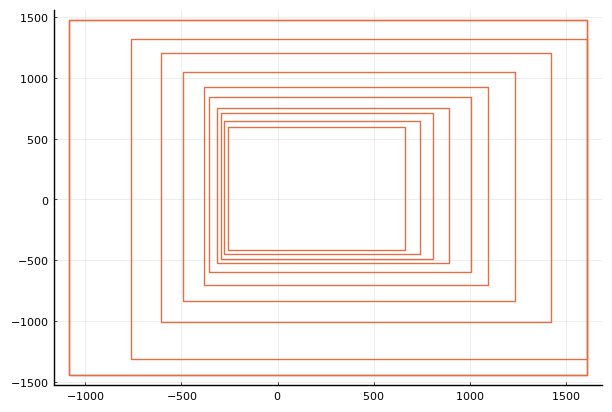

In [206]:
plt = plot()
todo_xs, todo_ys = x1s, x2s
plt = plotBoxes!(plt, todo_xs[:,1], todo_xs[:,2], todo_ys[:,1], todo_ys[:,2],
    color = colors[2],
    legend = false)
savefig(plt, joinpath(DUMP_DIR, "reach-box-x1-x2.png"))
# plt

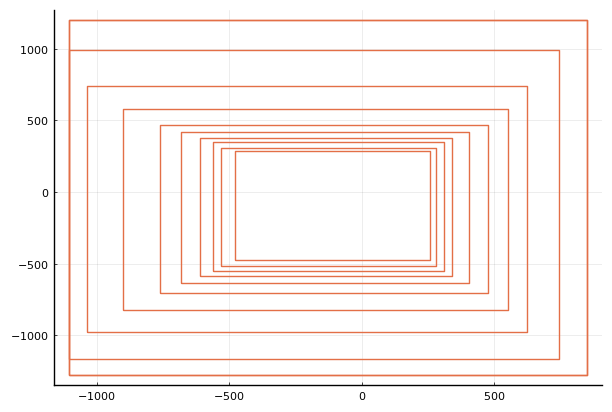

In [207]:
plt = plot()
todo_xs, todo_ys = x3s, x4s
plt = plotBoxes!(plt, todo_xs[:,1], todo_xs[:,2], todo_ys[:,1], todo_ys[:,2],
    color = colors[2],
    legend = false)
savefig(plt, joinpath(DUMP_DIR, "reach-box-x3-x4.png"))
# plt

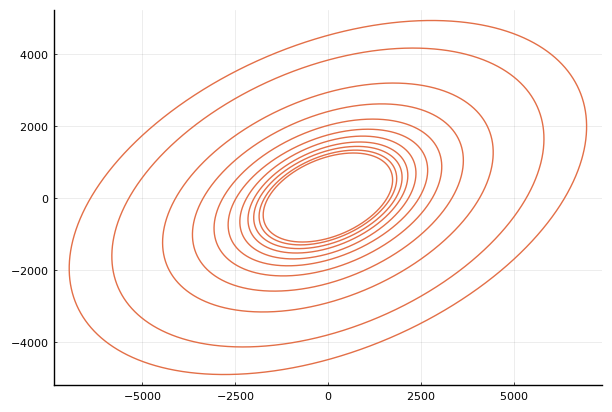

In [208]:
plt = plot()

# todo_ellipsoids = ellipsoids[inds]
todo_ellipsoids = ellipsoids

for (P, yc) in todo_ellipsoids
    Pp, ycp = P[1:2, 1:2], yc[1:2]
    plotEllipse!(plt, Pp, ycp, color=colors[2], legend=false)
end
savefig(plt, joinpath(DUMP_DIR, "reach-ellipsoid-x1-x2.png"))
# plt

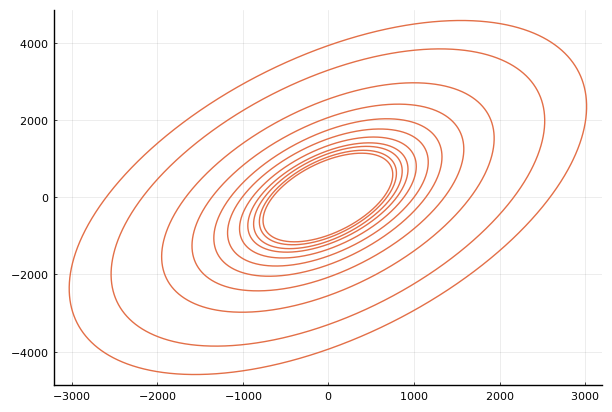

In [209]:
plt = plot()

# todo_ellipsoids = ellipsoids[inds]
todo_ellipsoids = ellipsoids

for (P, yc) in todo_ellipsoids
    Pp, ycp = P[3:4, 3:4], yc[3:4]
    plotEllipse!(plt, Pp, ycp, color=colors[2], legend=false)
end
savefig(plt, joinpath(DUMP_DIR, "reach-ellipsoid-x3-x4.png"))
# plt

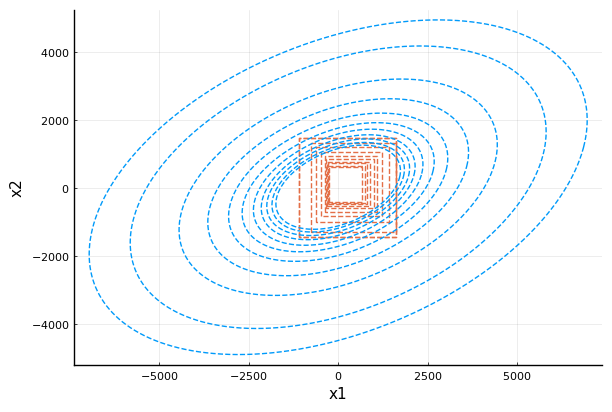

In [217]:
plt = plot()
todo_xs, todo_ys = x1s, x2s
plt = plotBoxes!(plt, todo_xs[:,1], todo_xs[:,2], todo_ys[:,1], todo_ys[:,2],
    color = colors[2],
    linestyle = :dash,
    legend = false)


# todo_ellipsoids = ellipsoids[inds]
todo_ellipsoids = ellipsoids

for (P, yc) in todo_ellipsoids
    Pp, ycp = P[1:2, 1:2], yc[1:2]
    plotEllipse!(plt, Pp, ycp, color=colors[1], legend=false, linestyle=:dash)
end

plt = plot!(plt, xlabel="x1", ylabel="x2")

savefig(plt, joinpath(DUMP_DIR, "reach-ellipbox-x1-x2.png"))
# plt

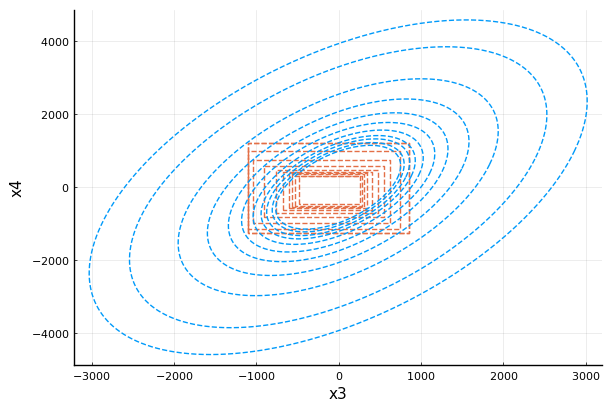

In [218]:
plt = plot()
todo_xs, todo_ys = x3s, x4s
plt = plotBoxes!(plt, todo_xs[:,1], todo_xs[:,2], todo_ys[:,1], todo_ys[:,2],
    color = colors[2],
    linestyle = :dash,
    legend = false)


# todo_ellipsoids = ellipsoids[inds]
todo_ellipsoids = ellipsoids

for (P, yc) in todo_ellipsoids
    Pp, ycp = P[3:4, 3:4], yc[3:4]
    plotEllipse!(plt, Pp, ycp, color=colors[1], legend=false, linestyle=:dash)
end


plt = plot!(plt, xlabel="x3", ylabel="x4")

savefig(plt, joinpath(DUMP_DIR, "reach-ellipbox-x3-x4.png"))
# plt